# Time Series Forecasting

## Import libraries

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings('ignore')

In [3]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

`live_adverts`

In [4]:
user_passports_desc = client.execute("""
DESCRIBE TABLE live_adverts
""")

user_passports_desc

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [5]:
query = '''
SELECT 
  la.*, 
  up.user_type_cars_name
FROM 
  live_adverts as la
LEFT JOIN 
  user_passports AS up on la.user_id= up.global_id
WHERE 
  la.created_at::Date = '2023-01-30' 
    AND la.price > 1000 
      AND la.year != '0'
'''

In [6]:
result = client.execute(query)

In [7]:
len(result)

33070

In [8]:
df = pd.DataFrame(result, 
                  columns=['execution_date', 'advert_id', 'created_at',
                           'price', 'region', 'user_id', 
                           'platform', 'auto_brand', 'auto_model',
                           'passport_id', 'year', 'userType',
                           'user_type_cars_name'])

df

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,userType,user_type_cars_name
0,2023-01-31,271540911,2023-01-30 00:00:17,620000,Сочи,151328585,ios,Chevrolet,Cruze,144703780,2010,0,cars_simple
1,2023-01-31,271540913,2023-01-30 00:01:21,4970000,Москва,123929189,android,Toyota,Land Cruiser,123950184,2013,6,cars_seller
2,2023-01-31,271540914,2023-01-30 00:04:42,800000,Москва,137723514,android,Subaru,Impreza,134075141,2006,0,cars_simple
3,2023-01-31,271540915,2023-01-30 00:04:57,280000,Пермь,142310446,android,Mitsubishi,RVR,137387157,1995,0,cars_simple
4,2023-01-31,271540920,2023-01-30 00:06:14,540000,Воронеж,152083420,android,Toyota,Previa,144920294,1994,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33065,2023-01-30,271586342,2023-01-30 17:53:08,194000,Казань,136396233,android,Unknown,Unknown model,133196873,2021,0,cars_simple
33066,2023-01-30,271586346,2023-01-30 17:53:21,1400000,Москва,123663563,android,Toyota,Camry,123684510,2007,0,cars_simple
33067,2023-01-30,271586370,2023-01-30 17:54:03,960000,Ростов-на-Дону,128075266,ios,Toyota,Camry,127561951,2007,0,cars_simple
33068,2023-01-30,271586391,2023-01-30 17:54:42,110000,Сочи,139693414,ios,ВАЗ (Lada),2115 (седан),135378755,2005,0,cars_simple


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33070 entries, 0 to 33069
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   execution_date       33070 non-null  object        
 1   advert_id            33070 non-null  int64         
 2   created_at           33070 non-null  datetime64[ns]
 3   price                33070 non-null  int64         
 4   region               33070 non-null  object        
 5   user_id              33070 non-null  int64         
 6   platform             33070 non-null  object        
 7   auto_brand           33070 non-null  object        
 8   auto_model           33070 non-null  object        
 9   passport_id          33070 non-null  int64         
 10  year                 33070 non-null  object        
 11  userType             33070 non-null  int64         
 12  user_type_cars_name  33070 non-null  object        
dtypes: datetime64[ns](1), int64(5),

In [10]:
df['execution_date'] = pd.to_datetime(df['execution_date'])

### Task 2. 

**Logarithmize the target variable. What was the mean value after the transformation?**

In [11]:
df['log_price'] = np.log(df['price'])

In [12]:
df['log_price'].mean()

13.302673141892646

### Task 3.  

**Sort the dataframe by `'execution_date', 'advert_id'`. Take the following features: `'region', 'platform', 'auto_brand', 'user_type_cars_name', 'year'`. Divide the features into categorical and numerical. How many categorical features were there?** 

In [13]:
df = df.sort_values(['execution_date', 'advert_id']).reset_index(drop=True)

In [14]:
data = df[['region', 'platform', 'auto_brand', 'user_type_cars_name', 'year']]

In [15]:
data.head()

,region,platform,auto_brand,user_type_cars_name,year
0,Самара,ios,ЗАЗ,cars_simple,2014
1,Сочи,ios,Chevrolet,cars_simple,2010
2,Москва,android,Toyota,cars_seller,2013
3,Москва,android,Subaru,cars_simple,2006
4,Пермь,android,Mitsubishi,cars_simple,1995


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33070 entries, 0 to 33069
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   region               33070 non-null  object
 1   platform             33070 non-null  object
 2   auto_brand           33070 non-null  object
 3   user_type_cars_name  33070 non-null  object
 4   year                 33070 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [17]:
data = data.astype({'year': 'int'})

A number of categorical features in the dataset:

In [18]:
data.select_dtypes(include='object').shape[1]

4

### Task 4. 

**Split the data to test and train. Process the data using StandardScaler for numeric data and OneHotEncoding for categorical data.**  

In [19]:
X_ = data
y_ = df['log_price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

In [21]:
processor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler().set_output(transform='pandas'), selector(dtype_include='number')),
        ('categorial', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas'), selector(dtype_exclude='number'))
    ],
    verbose_feature_names_out=False 
).set_output(transform='pandas') 

In [22]:
processor_test = processor.fit_transform(X_train)

processor_test

,year,region_Волгоград,region_Воронеж,region_Екатеринбург,region_Ижевск,region_Казань,region_Калининград,region_Краснодар,region_Красноярск,region_Москва,...,auto_brand_ИЖ,auto_brand_ЛуАЗ,auto_brand_Москвич,auto_brand_Ретро-автомобили,auto_brand_ТагАЗ,auto_brand_УАЗ,user_type_cars_name_,user_type_cars_name_cars_dealer,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple
12368,-1.080897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15555,-1.180276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1183,-1.180276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
907,-1.080897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12964,0.211026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,0.310404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6265,0.707919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11284,-1.080897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,0.211026,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
len(X_train)

26456

### Task 5. 

**Use grid search to find the best parameters for Decision Tree Regressior model.**

In [24]:
pipeline = Pipeline([
    ('processor', processor),
    ('model', DecisionTreeRegressor(random_state=42))
])

param_grid = {
    'model__max_depth': [2, 10, 15, 20],
    'model__min_samples_split': [10, 200, 5000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)


print('Best Parameters: ', grid_search.best_params_)

Best Parameters:  {'model__max_depth': 20, 'model__min_samples_split': 10}


### Task 6. 

**Run the best model on the test set and measure the quality using the R-squared metric (we have already used it before). What value did you get?**

In [25]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2_score(y_test, y_pred)

0.7518516532615556

### Task 7. 

**What feature is the most important for our model?**

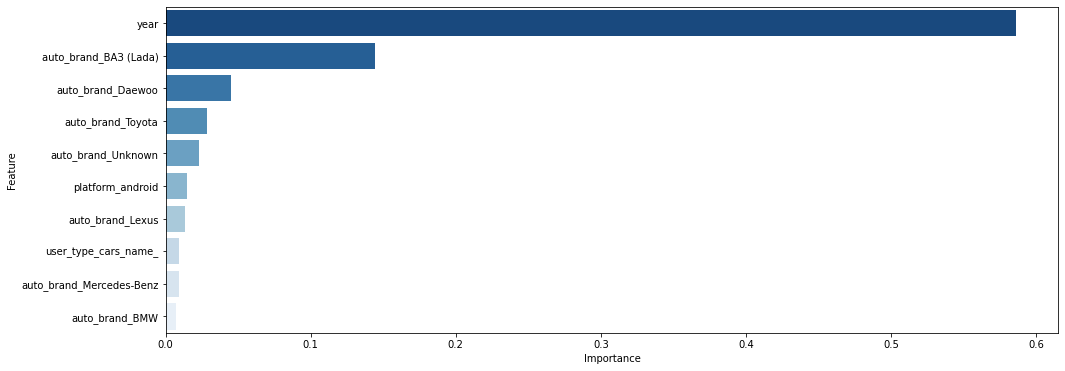

In [26]:
feature_importances = grid_search.best_estimator_['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': processor_test.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

fig = plt.figure()
fig.set_size_inches(16, 6)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')

plt.show()

### Task 8. 

**Perform grid search to find best parameters for a Random Forest Regressor model.**

In [27]:
pipeline = Pipeline([
    ('processor', processor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__max_depth': [2, 10, 15, 20],
    'model__min_samples_split': [10, 200, 5000],
    'model__n_estimators': [20, 50, 100]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)


print('Best Parameters: ', grid_search.best_params_)

Best Parameters:  {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 100}


In [28]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2_score(y_test, y_pred)

0.7779173370767432

### Task 9. 

**What feature is the most important for our model now?**

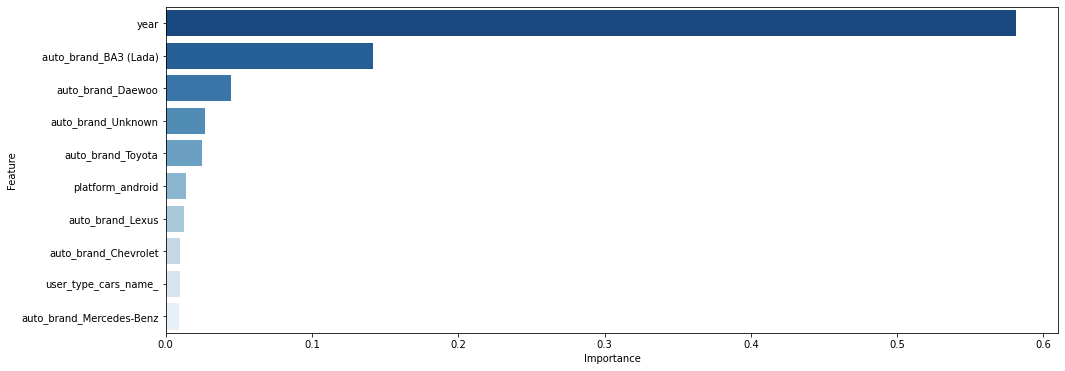

In [29]:
feature_importances = grid_search.best_estimator_['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': processor_test.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

fig = plt.figure()
fig.set_size_inches(16, 6)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')

plt.show()

In [30]:
set_a = {'year', 'vaz', 'dae', 'toy', 'unk', 'android', 'lexus', 'cars_name', 'benz', 'bmw'}

In [31]:
set_b = {'year', 'vaz', 'dae', 'unk', 'toy', 'android', 'lexus', 'cars_name', 'chev', 'benz'}

In [32]:
len(set_a)

10

In [33]:
len(set_b)

10

In [34]:
set_a.difference(set_b)

{'bmw'}

In [35]:
set_b.difference(set_a)

{'chev'}

### Task 10. 

**Train XGBRegressor model.**

In [36]:
pipeline = Pipeline([
    ('processor', processor),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=1, seed=0))
])

In [37]:
%time
pipeline.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 18.8 µs


Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd160>),
                                                 ('categorial',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd850>)],
                                   verbose_feature_names...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...))])

In [38]:
predictions = pipeline.predict(X_test) 
r2_score(y_test, predictions)

0.7679111287521171

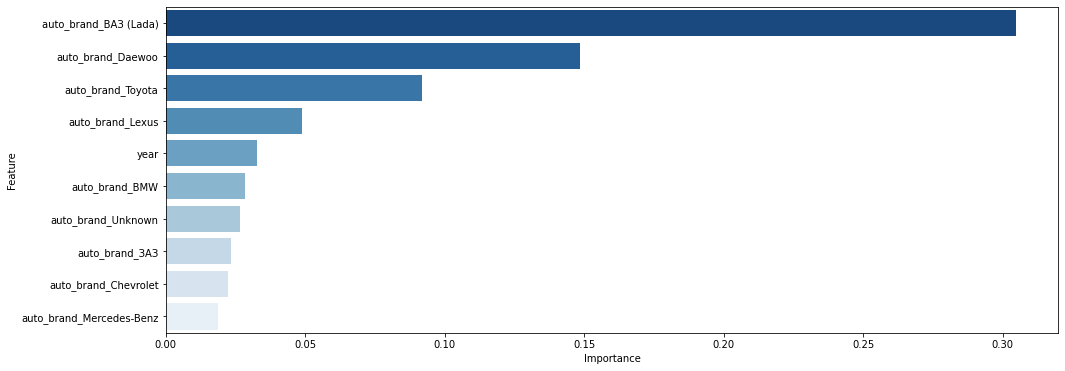

In [39]:
feature_importances = pipeline['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': processor_test.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

fig = plt.figure()
fig.set_size_inches(16, 6)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')

plt.show()

### Task 11.  

**Train CatBoostRegressor model.**

In [40]:
pipeline = Pipeline([
    ('processor', processor),
    ('model', CatBoostRegressor(random_state=42))
])

In [41]:
%time
pipeline.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Learning rate set to 0.068697
0:	learn: 1.0643959	total: 52.3ms	remaining: 52.3s
1:	learn: 1.0246687	total: 56.2ms	remaining: 28.1s
2:	learn: 0.9882237	total: 60.2ms	remaining: 20s
3:	learn: 0.9552513	total: 63.5ms	remaining: 15.8s
4:	learn: 0.9253217	total: 66.9ms	remaining: 13.3s
5:	learn: 0.8981365	total: 70.3ms	remaining: 11.6s
6:	learn: 0.8732483	total: 73.8ms	remaining: 10.5s
7:	learn: 0.8508494	total: 77.2ms	remaining: 9.58s
8:	learn: 0.8307539	total: 80.6ms	remaining: 8.87s
9:	learn: 0.8114891	total: 84ms	remaining: 8.32s
10:	learn: 0.7944838	total: 87.3ms	remaining: 7.85s
11:	learn: 0.7799357	total: 90.9ms	remaining: 7.48s
12:	learn: 0.7660331	total: 94.3ms	remaining: 7.16s
13:	learn: 0.7524553	total: 97.4ms	remaining: 6.86s
14:	learn: 0.7407331	total: 100ms	remaining: 6.58s
15:	learn: 0.7305142	total: 103ms	remaining: 6.33s
16:	learn: 0.7212861	total: 106ms	remaining: 6.11s
17:	learn: 0.7130342	total: 108ms	remai

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd160>),
                                                 ('categorial',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd850>)],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fd1ba126a00>)])

In [42]:
predictions = pipeline.predict(X_test) 
r2_score(y_test, predictions)

0.7659046645374286

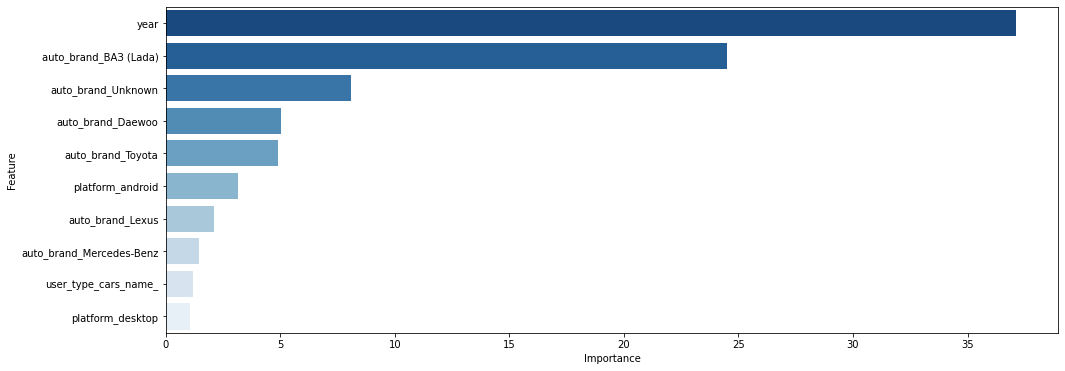

In [43]:
feature_importances = pipeline['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': processor_test.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

fig = plt.figure()
fig.set_size_inches(16, 6)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')

plt.show()

### Task 12. 

**Add `auto_model` feature to our data and train the best model.**

In [44]:
data = df[['region', 'platform', 'auto_brand', 'user_type_cars_name', 'year', 'auto_model']]

In [45]:
data

,region,platform,auto_brand,user_type_cars_name,year,auto_model
0,Самара,ios,ЗАЗ,cars_simple,2014,Chance
1,Сочи,ios,Chevrolet,cars_simple,2010,Cruze
2,Москва,android,Toyota,cars_seller,2013,Land Cruiser
3,Москва,android,Subaru,cars_simple,2006,Impreza
4,Пермь,android,Mitsubishi,cars_simple,1995,RVR
...,...,...,...,...,...,...
33065,Новосибирск,android,Unknown,cars_simple,2007,Unknown model
33066,Новосибирск,ios,ВАЗ (Lada),cars_simple,2012,Priora 2170 (седан)
33067,Новосибирск,android,Chevrolet,cars_simple,2021,Cobalt
33068,Москва,desktop,Mercedes-Benz,cars_simple,2002,C 320


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33070 entries, 0 to 33069
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   region               33070 non-null  object
 1   platform             33070 non-null  object
 2   auto_brand           33070 non-null  object
 3   user_type_cars_name  33070 non-null  object
 4   year                 33070 non-null  object
 5   auto_model           33070 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [47]:
data = data.astype({'year': 'int'})

In [48]:
X_ = data
y_ = df['log_price']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

In [50]:
pipeline = Pipeline([
    ('processor', processor),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=1, seed=0))
])

In [51]:
%time
pipeline.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd160>),
                                                 ('categorial',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1baefd850>)],
                                   verbose_feature_names...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...))])

In [52]:
predictions = pipeline.predict(X_test) 
r2_score(y_test, predictions)

0.7950614538820766

We can see that we have improved predictions of our model by adding a new feature. 